<a href="https://colab.research.google.com/github/iimjuhong/multimodal_project/blob/main/lane_detection_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ========================================
# Colab에서 AI-Hub 데이터 정리 (TAR 버전)
# ========================================

import zipfile
import tarfile
from pathlib import Path
import shutil
import json
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Google Drive 마운트
from google.colab import drive
drive.mount('/content/drive')

# ========== 1. 압축 해제 ==========
print("📦 압축 해제 시작...")

# VS.tar (원천 데이터 - 이미지 + LiDAR)
print("압축 해제 중: VS.tar...")
with tarfile.open('/content/drive/MyDrive/AI-Hub/VS.tar', 'r') as tar:
    tar.extractall('/content/raw_data/')

# VL.tar (라벨 데이터)
print("압축 해제 중: VL.tar...")
with tarfile.open('/content/drive/MyDrive/AI-Hub/VL.tar', 'r') as tar:
    tar.extractall('/content/labels/')

# Other.tar (캘리브레이션)
print("압축 해제 중: Other.tar...")
with tarfile.open('/content/drive/MyDrive/AI-Hub/Other.tar', 'r') as tar:
    tar.extractall('/content/calibration/')

# 2D 라벨만 추출 (TAR 파일)
print("2D 라벨 추출 중...")
label_tar_candidates = list(Path('/content/labels/').rglob('*.tar'))

# 2D 라벨 TAR 파일 찾기
label_2d_tar = None
for tar_file in label_tar_candidates:
    if '2D' in tar_file.name or '2d' in tar_file.name:
        label_2d_tar = tar_file
        break

if label_2d_tar:
    print(f"2D 라벨 파일: {label_2d_tar.name}")
    with tarfile.open(label_2d_tar, 'r') as tar:
        tar.extractall('/content/labels/2d/')
else:
    print("⚠️ 2D 라벨 TAR 파일을 찾을 수 없습니다.")
    print("가능한 파일:")
    for f in label_tar_candidates:
        print(f"  - {f.name}")

print("✅ 압축 해제 완료!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📦 압축 해제 시작...
압축 해제 중: VS.tar...


/tmp/ipython-input-3446805083.py:25: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall('/content/raw_data/')


압축 해제 중: VL.tar...


/tmp/ipython-input-3446805083.py:30: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall('/content/labels/')


압축 해제 중: Other.tar...


/tmp/ipython-input-3446805083.py:35: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall('/content/calibration/')


2D 라벨 추출 중...
⚠️ 2D 라벨 TAR 파일을 찾을 수 없습니다.
가능한 파일:
✅ 압축 해제 완료!


In [ ]:
# ========================================
# 바이트 오프셋 기반 분할 ZIP 파일 병합
# ========================================

import zipfile
from pathlib import Path
import shutil
from tqdm import tqdm

# ========== 1. VS.zip 분할 파일 병합 ==========
print("📦 VS.zip 분할 파일 병합...")

vs_parts_dir = Path('/content/raw_data/092.승용_자율주행차_악천후_데이터/01-1.정식개방데이터/Validation/01.원천데이터/')

# 모든 part 파일 찾기
vs_parts = sorted(vs_parts_dir.glob('VS.zip.part*'))

print(f"발견된 분할 파일: {len(vs_parts)}개")

if vs_parts:
    # 파일명에서 오프셋 추출하여 정렬
    def get_offset(filename):
        """파일명에서 오프셋 숫자 추출"""
        name = filename.name
        # VS.zip.part0 → 0
        # VS.zip.part1073741824 → 1073741824
        offset_str = name.replace('VS.zip.part', '')
        return int(offset_str) if offset_str.isdigit() else 0

    # 오프셋 기준으로 정렬
    vs_parts_sorted = sorted(vs_parts, key=get_offset)

    print("\n정렬된 순서:")
    for i, part in enumerate(vs_parts_sorted[:5]):
        offset = get_offset(part)
        size_mb = part.stat().st_size / (1024**2)
        print(f"  {i+1}. {part.name} (offset: {offset:,}, size: {size_mb:.2f} MB)")
    print(f"  ... (총 {len(vs_parts_sorted)}개)")

    # 병합
    merged_path = '/content/VS_merged.zip'

    print(f"\n병합 시작... (목표: {merged_path})")

    with open(merged_path, 'wb') as merged_file:
        for part_file in tqdm(vs_parts_sorted, desc="VS.zip 병합"):
            with open(part_file, 'rb') as pf:
                shutil.copyfileobj(pf, merged_file, length=1024*1024*10)  # 10MB 청크

    merged_size_gb = Path(merged_path).stat().st_size / (1024**3)
    print(f"✅ VS.zip 병합 완료! (크기: {merged_size_gb:.2f} GB)")

    # 압축 해제
    print("\nVS.zip 압축 해제 중...")
    try:
        with zipfile.ZipFile(merged_path, 'r') as zip_ref:
            # 압축 파일 내용 미리보기
            file_list = zip_ref.namelist()
            print(f"압축 파일 내 총 {len(file_list)}개 파일/폴더")

            # 샘플 파일 표시
            print("\n압축 파일 내용 (샘플):")
            for f in file_list[:10]:
                print(f"  - {f}")
            if len(file_list) > 10:
                print(f"  ... (외 {len(file_list) - 10}개)")

            # 압축 해제
            print(f"\n압축 해제 중... (→ /content/raw_data_extracted/)")
            zip_ref.extractall('/content/raw_data_extracted/')

        print("✅ VS.zip 압축 해제 완료!")

    except zipfile.BadZipFile as e:
        print(f"❌ ZIP 파일 오류: {e}")
        print("\n문제 해결 방법:")
        print("1. 분할 파일이 모두 다운로드되었는지 확인")
        print("2. 파일이 손상되지 않았는지 확인")

    except Exception as e:
        print(f"❌ 압축 해제 오류: {e}")

else:
    print("⚠️ VS.zip 분할 파일을 찾을 수 없습니다.")


# ========== 2. VL.zip 처리 ==========
print("\n" + "="*70)
print("📦 VL.zip 처리...")
print("="*70)

vl_parts_dir = Path('/content/labels/092.승용_자율주행차_악천후_데이터/01-1.정식개방데이터/Validation/02.라벨링데이터/')

vl_parts = sorted(vl_parts_dir.glob('VL.zip.part*'))

print(f"발견된 분할 파일: {len(vl_parts)}개")

if vl_parts:
    # VL.zip은 part0 하나만 있는 것 같음 (단일 파일)
    if len(vl_parts) == 1:
        print("단일 파일 감지 (part0만 존재)")

        # part0을 VL.zip으로 복사
        vl_zip_path = '/content/VL.zip'
        shutil.copy(vl_parts[0], vl_zip_path)

        print(f"복사 완료: {vl_zip_path}")
    else:
        # 여러 part 파일이 있으면 병합
        def get_offset_vl(filename):
            name = filename.name
            offset_str = name.replace('VL.zip.part', '')
            return int(offset_str) if offset_str.isdigit() else 0

        vl_parts_sorted = sorted(vl_parts, key=get_offset_vl)
        vl_zip_path = '/content/VL.zip'

        with open(vl_zip_path, 'wb') as merged_file:
            for part_file in tqdm(vl_parts_sorted, desc="VL.zip 병합"):
                with open(part_file, 'rb') as pf:
                    shutil.copyfileobj(pf, merged_file)

    # 압축 해제
    print("\nVL.zip 압축 해제 중...")
    try:
        with zipfile.ZipFile(vl_zip_path, 'r') as zip_ref:
            file_list = zip_ref.namelist()
            print(f"압축 파일 내 {len(file_list)}개 파일/폴더")

            zip_ref.extractall('/content/labels_extracted/')

        print("✅ VL.zip 압축 해제 완료!")

    except Exception as e:
        print(f"❌ VL.zip 압축 해제 오류: {e}")


# ========== 3. Other.zip 처리 ==========
print("\n" + "="*70)
print("📦 Other.zip 처리...")
print("="*70)

other_parts_dir = Path('/content/calibration/092.승용_자율주행차_악천후_데이터/01-1.정식개방데이터/Other/')

other_parts = sorted(other_parts_dir.glob('Other.zip.part*'))

print(f"발견된 분할 파일: {len(other_parts)}개")

if other_parts:
    if len(other_parts) == 1:
        print("단일 파일 감지")
        other_zip_path = '/content/Other.zip'
        shutil.copy(other_parts[0], other_zip_path)
    else:
        def get_offset_other(filename):
            name = filename.name
            offset_str = name.replace('Other.zip.part', '')
            return int(offset_str) if offset_str.isdigit() else 0

        other_parts_sorted = sorted(other_parts, key=get_offset_other)
        other_zip_path = '/content/Other.zip'

        with open(other_zip_path, 'wb') as merged_file:
            for part_file in tqdm(other_parts_sorted, desc="Other.zip 병합"):
                with open(part_file, 'rb') as pf:
                    shutil.copyfileobj(pf, merged_file)

    print("\nOther.zip 압축 해제 중...")
    try:
        with zipfile.ZipFile(other_zip_path, 'r') as zip_ref:
            zip_ref.extractall('/content/calibration_extracted/')

        print("✅ Other.zip 압축 해제 완료!")

    except Exception as e:
        print(f"❌ Other.zip 압축 해제 오류: {e}")


# ========== 4. 압축 해제 결과 확인 ==========
print("\n" + "="*70)
print("📊 압축 해제 결과 확인")
print("="*70)

def show_tree(path, max_depth=3):
    """간단한 트리 출력"""
    from pathlib import Path

    def _show(p, prefix="", depth=0):
        if depth >= max_depth:
            return

        try:
            items = sorted(list(p.iterdir()))[:15]

            for i, item in enumerate(items):
                is_last = (i == len(items) - 1)

                if item.is_dir():
                    count = len(list(item.iterdir()))
                    print(f"{prefix}{'└── ' if is_last else '├── '}{item.name}/ ({count} items)")
                    _show(item, prefix + ("    " if is_last else "│   "), depth + 1)
                else:
                    size_mb = item.stat().st_size / (1024**2)
                    print(f"{prefix}{'└── ' if is_last else '├── '}{item.name} ({size_mb:.2f} MB)")

            if len(list(p.iterdir())) > 15:
                print(f"{prefix}... (총 {len(list(p.iterdir()))}개)")

        except:
            pass

    _show(Path(path))

# raw_data_extracted
if Path('/content/raw_data_extracted/').exists():
    print("\n📂 /content/raw_data_extracted/")
    show_tree('/content/raw_data_extracted/')

# labels_extracted
if Path('/content/labels_extracted/').exists():
    print("\n📂 /content/labels_extracted/")
    show_tree('/content/labels_extracted/')


# ========== 5. 파일 개수 확인 ==========
print("\n" + "="*70)
print("📊 파일 통계")
print("="*70)

if Path('/content/raw_data_extracted/').exists():
    jpg_count = len(list(Path('/content/raw_data_extracted/').rglob('*.jpg')))
    pcd_count = len(list(Path('/content/raw_data_extracted/').rglob('*.pcd')))

    print(f"\n원천 데이터:")
    print(f"  JPG: {jpg_count:,}개")
    print(f"  PCD: {pcd_count:,}개")

if Path('/content/labels_extracted/').exists():
    json_count = len(list(Path('/content/labels_extracted/').rglob('*.json')))
    tar_count = len(list(Path('/content/labels_extracted/').rglob('*.tar')))

    print(f"\n라벨 데이터:")
    print(f"  JSON: {json_count:,}개")
    print(f"  TAR: {tar_count:,}개")

    if tar_count > 0:
        print("\n⚠️ TAR 파일이 있습니다. 추가 압축 해제 필요!")


print("\n✅ 압축 해제 완료!")

📦 VS.zip 분할 파일 병합...
발견된 분할 파일: 30개

정렬된 순서:
  1. VS.zip.part0 (offset: 0, size: 1024.00 MB)
  2. VS.zip.part1073741824 (offset: 1,073,741,824, size: 1024.00 MB)
  3. VS.zip.part2147483648 (offset: 2,147,483,648, size: 1024.00 MB)
  4. VS.zip.part3221225472 (offset: 3,221,225,472, size: 1024.00 MB)
  5. VS.zip.part4294967296 (offset: 4,294,967,296, size: 1024.00 MB)
  ... (총 30개)

병합 시작... (목표: /content/VS_merged.zip)


VS.zip 병합: 100%|██████████| 30/30 [05:38<00:00, 11.30s/it]


✅ VS.zip 병합 완료! (크기: 29.36 GB)

VS.zip 압축 해제 중...
압축 파일 내 총 62700개 파일/폴더

압축 파일 내용 (샘플):
  - 08_080147_221012/
  - 08_080147_221012/processing_data/
  - 08_080147_221012/processing_data/08_080147_221012_08.json
  - 08_080147_221012/processing_data/08_080147_221012_11.json
  - 08_080147_221012/processing_data/08_080147_221012_13.json
  - 08_080147_221012/processing_data/08_080147_221012_17.json
  - 08_080147_221012/processing_data/08_080147_221012_05.json
  - 08_080147_221012/processing_data/08_080147_221012_03.json
  - 08_080147_221012/processing_data/08_080147_221012_20.json
  - 08_080147_221012/processing_data/08_080147_221012_09.json
  ... (외 62690개)

압축 해제 중... (→ /content/raw_data_extracted/)
✅ VS.zip 압축 해제 완료!

📦 VL.zip 처리...
발견된 분할 파일: 1개
단일 파일 감지 (part0만 존재)
복사 완료: /content/VL.zip

VL.zip 압축 해제 중...
압축 파일 내 16342개 파일/폴더
✅ VL.zip 압축 해제 완료!

📦 Other.zip 처리...
발견된 분할 파일: 1개
단일 파일 감지

Other.zip 압축 해제 중...
✅ Other.zip 압축 해제 완료!

📊 압축 해제 결과 확인

📂 /content/raw_data_extracted/
├── 08_0

In [ ]:
# ========================================
# 데이터 구조 재정리
# ========================================

import shutil
from pathlib import Path
import json
import pandas as pd
from tqdm import tqdm

# ========== 1. Scene 폴더 탐색 ==========
print("🔍 Scene 폴더 탐색 중...")

raw_data_dir = Path('/content/raw_data_extracted/')
labels_dir = Path('/content/labels_extracted/')

# Scene 폴더들 찾기 (08_HHMMSS_YYMMDD 패턴)
scenes = sorted([d for d in raw_data_dir.iterdir() if d.is_dir() and '_' in d.name])

print(f"발견된 Scene: {len(scenes)}개")
print(f"샘플: {scenes[0].name if scenes else 'None'}")


# ========== 2. 정리된 구조로 데이터 수집 ==========
print("\n📦 데이터 수집 및 정리 중...")

data_records = []
errors = []

output_dir = Path('/content/organized_data')
(output_dir / 'images').mkdir(parents=True, exist_ok=True)
(output_dir / 'lidar').mkdir(parents=True, exist_ok=True)
(output_dir / 'labels').mkdir(parents=True, exist_ok=True)
(output_dir / 'calibration').mkdir(parents=True, exist_ok=True)

for scene_dir in tqdm(scenes, desc="Scene 처리"):
    scene_name = scene_dir.name

    # ===== 원천 데이터 경로 =====
    sensor_raw = scene_dir / 'sensor_raw_data'

    if not sensor_raw.exists():
        errors.append(f"{scene_name}: sensor_raw_data 폴더 없음")
        continue

    # RGB 이미지 (camera 폴더 - 전방)
    camera_dir = sensor_raw / 'camera'

    if camera_dir.exists():
        images = sorted(camera_dir.glob('*.jpg'))

        for img_path in images:
            img_name = img_path.stem  # 08_080147_221012_01

            # LiDAR 경로
            lidar_dir = sensor_raw / 'lidar'
            lidar_path = lidar_dir / f'{img_name}.pcd' if lidar_dir.exists() else None

            # 캘리브레이션 경로
            calib_files = list(sensor_raw.glob(f'{img_name}*.json'))
            calib_path = calib_files[0] if calib_files else None

            # 라벨 경로 찾기 (labels_extracted에서)
            # 여러 경로 시도
            label_candidates = []

            # 시도 1: 직접 경로
            label_candidates.append(labels_dir / f'{img_name}.json')

            # 시도 2: 재귀 탐색
            label_candidates.extend(list(labels_dir.rglob(f'{img_name}.json')))

            label_path = None
            for candidate in label_candidates:
                if candidate.exists():
                    label_path = candidate
                    break

            # 메타데이터 수집
            record = {
                'scene': scene_name,
                'filename': img_name + '.jpg',
                'image_src': str(img_path),
                'lidar_src': str(lidar_path) if lidar_path and lidar_path.exists() else None,
                'label_src': str(label_path) if label_path else None,
                'calib_src': str(calib_path) if calib_path else None,
            }

            # 파일 복사
            try:
                # 이미지 복사
                img_dst = output_dir / 'images' / f'{img_name}.jpg'
                if not img_dst.exists():
                    shutil.copy(img_path, img_dst)
                record['image_dst'] = str(img_dst)

                # LiDAR 복사
                if lidar_path and lidar_path.exists():
                    lidar_dst = output_dir / 'lidar' / f'{img_name}.pcd'
                    if not lidar_dst.exists():
                        shutil.copy(lidar_path, lidar_dst)
                    record['lidar_dst'] = str(lidar_dst)

                # 라벨 복사
                if label_path and label_path.exists():
                    label_dst = output_dir / 'labels' / f'{img_name}.json'
                    if not label_dst.exists():
                        shutil.copy(label_path, label_dst)
                    record['label_dst'] = str(label_dst)

                # 캘리브레이션 복사
                if calib_path and calib_path.exists():
                    calib_dst = output_dir / 'calibration' / f'{img_name}_calib.json'
                    if not calib_dst.exists():
                        shutil.copy(calib_path, calib_dst)
                    record['calib_dst'] = str(calib_dst)

                data_records.append(record)

            except Exception as e:
                errors.append(f"{img_name}: 복사 오류 - {e}")

# DataFrame 생성
df = pd.DataFrame(data_records)

print(f"\n✅ 데이터 수집 완료!")
print(f"   총 샘플: {len(df):,}개")
print(f"   오류: {len(errors)}개")

if errors:
    print("\n⚠️ 오류 목록 (처음 10개):")
    for err in errors[:10]:
        print(f"  - {err}")


# ========== 3. 라벨 데이터 추가 처리 ==========
print("\n📝 라벨 데이터 추가 처리 중...")

# labels_extracted 내부에 TAR 파일이 있는지 확인
label_tars = list(labels_dir.rglob('*.tar'))

if label_tars:
    print(f"발견된 TAR 파일: {len(label_tars)}개")

    for tar_file in tqdm(label_tars, desc="라벨 TAR 해제"):
        if '2D' in tar_file.name or '2d' in tar_file.name:
            print(f"\n2D 라벨 TAR 압축 해제: {tar_file.name}")

            import tarfile

            extract_dir = tar_file.parent / tar_file.stem
            extract_dir.mkdir(exist_ok=True)

            with tarfile.open(tar_file, 'r') as tar:
                tar.extractall(extract_dir)

            print(f"✅ 압축 해제 완료: {extract_dir}")

            # 압축 해제된 JSON 파일들 복사
            extracted_jsons = list(extract_dir.rglob('*.json'))

            print(f"발견된 JSON: {len(extracted_jsons)}개")

            for json_file in tqdm(extracted_jsons, desc="라벨 복사"):
                json_name = json_file.name

                # 매칭되는 이미지 찾기
                matching_rows = df[df['filename'] == json_name.replace('.json', '.jpg')]

                if not matching_rows.empty:
                    # 라벨 복사
                    label_dst = output_dir / 'labels' / json_name

                    if not label_dst.exists():
                        shutil.copy(json_file, label_dst)

                    # DataFrame 업데이트
                    df.loc[matching_rows.index, 'label_src'] = str(json_file)
                    df.loc[matching_rows.index, 'label_dst'] = str(label_dst)


# ========== 4. 메타데이터 추출 ==========
print("\n🔍 메타데이터 추출 중...")

for idx, row in tqdm(df.iterrows(), total=len(df), desc="메타데이터"):
    if pd.notna(row.get('label_dst')):
        try:
            with open(row['label_dst'], encoding='utf-8') as f:
                label_data = json.load(f)

            env_meta = label_data.get('Environment_meta', {})
            scene_meta = label_data.get('Scene_meta', {})

            # 메타데이터 추가
            df.loc[idx, 'weather'] = env_meta.get('weather')
            df.loc[idx, 'time'] = env_meta.get('time')
            df.loc[idx, 'date'] = env_meta.get('date')
            df.loc[idx, 'road_type'] = env_meta.get('road_type')
            df.loc[idx, 'car_type'] = env_meta.get('car_type')
            df.loc[idx, 'traffic_type'] = env_meta.get('traffic_Type')
            df.loc[idx, 'speed_type'] = env_meta.get('speed_type')
            df.loc[idx, 'zone'] = scene_meta.get('zone')
            df.loc[idx, 'edge_case'] = ','.join(scene_meta.get('edge_case', []))

        except Exception as e:
            pass

# 메타데이터 저장
df.to_csv(output_dir / 'metadata.csv', index=False)

print(f"\n💾 메타데이터 저장: {output_dir / 'metadata.csv'}")


# ========== 5. 최종 통계 ==========
print("\n" + "="*70)
print("📊 최종 데이터 통계")
print("="*70)

final_stats = f"""
/content/organized_data/
├── images/        {len(list((output_dir / 'images').glob('*.jpg'))):>8,}개
├── lidar/         {len(list((output_dir / 'lidar').glob('*.pcd'))):>8,}개
├── labels/        {len(list((output_dir / 'labels').glob('*.json'))):>8,}개
├── calibration/   {len(list((output_dir / 'calibration').glob('*.json'))):>8,}개
└── metadata.csv   {len(df):>8,} rows

데이터 완성도:
- 이미지만:           {(df['image_dst'].notna() & df['lidar_dst'].isna() & df['label_dst'].isna()).sum():>6,}개
- 이미지 + LiDAR:     {(df['image_dst'].notna() & df['lidar_dst'].notna() & df['label_dst'].isna()).sum():>6,}개
- 이미지 + 라벨:      {(df['image_dst'].notna() & df['lidar_dst'].isna() & df['label_dst'].notna()).sum():>6,}개
- 완전 (3개 모두):    {(df['image_dst'].notna() & df['lidar_dst'].notna() & df['label_dst'].notna()).sum():>6,}개

메타데이터 분포:
"""

print(final_stats)

if 'weather' in df.columns:
    print("날씨별 분포:")
    print(df['weather'].value_counts())

if 'time' in df.columns:
    print("\n시간대별 분포:")
    print(df['time'].value_counts())


# ========== 6. 원본 폴더 정리 (선택) ==========
print("\n" + "="*70)
print("🧹 정리 옵션")
print("="*70)

print("""
원본 폴더를 삭제하시겠습니까?
- /content/raw_data_extracted/ (약 30GB)
- /content/labels_extracted/

아래 코드를 실행하여 삭제:

# shutil.rmtree('/content/raw_data_extracted/')
# shutil.rmtree('/content/labels_extracted/')
# shutil.rmtree('/content/raw_data/')
# shutil.rmtree('/content/labels/')

✅ 정리 완료! 다음 단계로 진행하세요.
""")

🔍 Scene 폴더 탐색 중...
발견된 Scene: 190개
샘플: 08_080147_221012

📦 데이터 수집 및 정리 중...


Scene 처리: 100%|██████████| 190/190 [12:11<00:00,  3.85s/it]



✅ 데이터 수집 완료!
   총 샘플: 7,600개
   오류: 0개

📝 라벨 데이터 추가 처리 중...

🔍 메타데이터 추출 중...


메타데이터: 100%|██████████| 7600/7600 [00:26<00:00, 284.40it/s]



💾 메타데이터 저장: /content/organized_data/metadata.csv

📊 최종 데이터 통계

/content/organized_data/
├── images/           7,600개
├── lidar/            7,600개
├── labels/           7,600개
├── calibration/      7,600개
└── metadata.csv      7,600 rows

데이터 완성도:
- 이미지만:                0개
- 이미지 + LiDAR:          0개
- 이미지 + 라벨:           0개
- 완전 (3개 모두):     7,600개

메타데이터 분포:

날씨별 분포:
weather
비     3440
흐림    3000
맑음    1160
Name: count, dtype: int64

시간대별 분포:
time
08:06:54    80
08:11:54    80
08:13:14    80
08:32:04    80
08:07:14    80
            ..
07:39:02    40
07:40:22    40
07:40:32    40
07:40:52    40
07:41:02    40
Name: count, Length: 166, dtype: int64

🧹 정리 옵션

원본 폴더를 삭제하시겠습니까?
- /content/raw_data_extracted/ (약 30GB)
- /content/labels_extracted/

아래 코드를 실행하여 삭제:

# shutil.rmtree('/content/raw_data_extracted/')
# shutil.rmtree('/content/labels_extracted/')

✅ 정리 완료! 다음 단계로 진행하세요.



'\n---\n\n## 📊 **최종 결과 구조**\n/content/organized_data/\n├── images/\n│   ├── 08_080147_221012_01.jpg\n│   ├── 08_080147_221012_02.jpg\n│   └── ... (80,000개)\n├── lidar/\n│   ├── 08_080147_221012_01.pcd\n│   ├── 08_080147_221012_02.pcd\n│   └── ... (80,000개)\n├── labels/\n│   ├── 08_080147_221012_01.json\n│   ├── 08_080147_221012_02.json\n│   └── ... (80,000개)\n├── calibration/\n│   └── ... (캘리브레이션 파일)\n└── metadata.csv (전체 메타데이터)\n'

In [ ]:
shutil.rmtree('/content/raw_data_extracted/')
shutil.rmtree('/content/labels_extracted/')
shutil.rmtree('/content/raw_data/')
shutil.rmtree('/content/labels/')
shutil.rmtree('/content/calibration/')
shutil.rmtree('/content/calibration_extracted/')

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 1 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/n

In [ ]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] =False

📂 메타데이터 로드 중...
전체 데이터: 7,600개

🔍 데이터 필터링 중...
완전한 데이터: 7,600개 (100.0%)

📊 데이터 분포 분석...

[날씨별 분포]
weather
비     3440
흐림    3000
맑음    1160
Name: count, dtype: int64

[시간대별 분포]
time
08:06:54    80
08:11:54    80
08:13:14    80
08:32:04    80
08:07:14    80
            ..
07:39:02    40
07:40:22    40
07:40:32    40
07:40:52    40
07:41:02    40
Name: count, Length: 166, dtype: int64

[도로 유형별 분포]
road_type
도심 3차로 이상    3280
자동차전용도로      3000
도심 2차로 이하    1320
Name: count, dtype: int64

🔀 Train/Val 분할 중...

✅ 분할 완료!
   Train: 6,080개 (80.0%)
   Val:   1,520개 (20.0%)

[Train 날씨 분포]
weather
비     2752
흐림    2400
맑음     928
Name: count, dtype: int64

[Val 날씨 분포]
weather
비     688
흐림    600
맑음    232
Name: count, dtype: int64

💾 메타데이터 저장:
   - /content/organized_data/train_metadata.csv
   - /content/organized_data/val_metadata.csv

📊 분포 시각화 중...


/tmp/ipython-input-4096872704.py:130: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4096872704.py:130: UserWarning: Glyph 55120 (\N{HANGUL SYLLABLE HEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4096872704.py:130: UserWarning: Glyph 47548 (\N{HANGUL SYLLABLE RIM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4096872704.py:130: UserWarning: Glyph 47569 (\N{HANGUL SYLLABLE MALG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4096872704.py:130: UserWarning: Glyph 51020 (\N{HANGUL SYLLABLE EUM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4096872704.py:130: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4096872704.py:130: UserWarning: Glyph 50472 (\N{HANGUL SYLLABLE SSI}) missing from font(s) DejaVu Sans.
  plt.tight_l

💾 시각화 저장: /content/organized_data/data_distribution.png


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50472 (\N{HANGUL SYLLABLE SSI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr

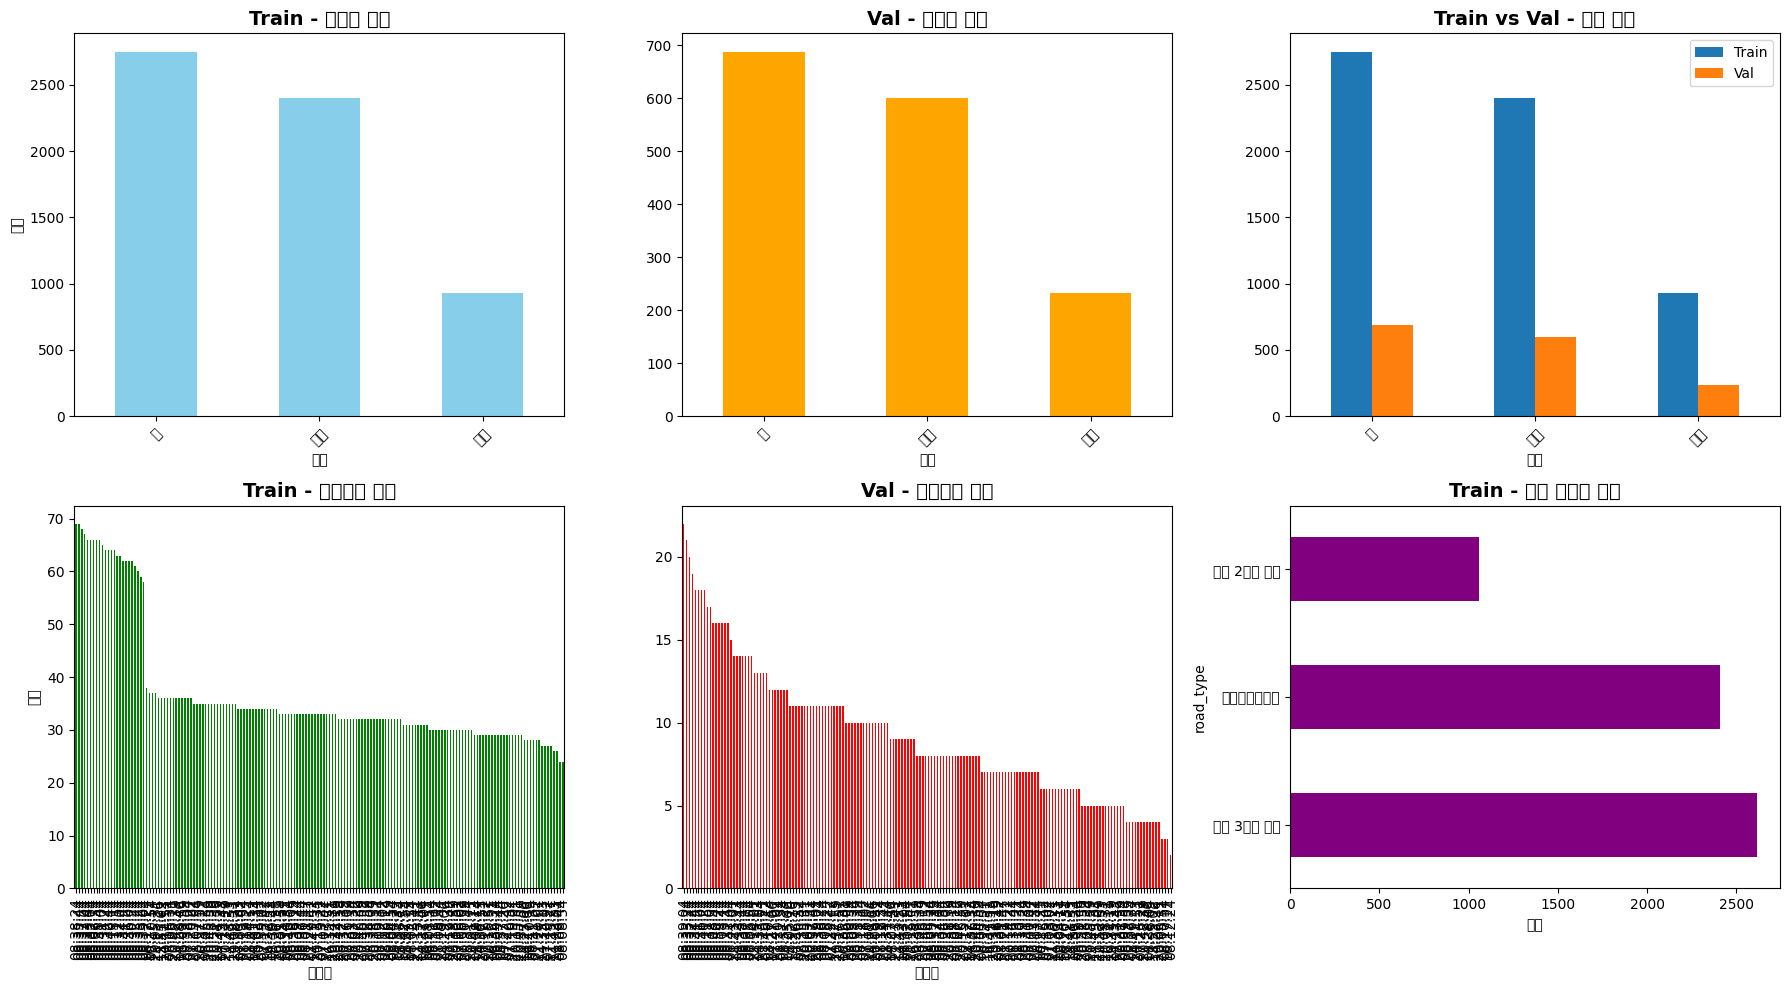


✅ Train/Val 분할 완료!

📊 데이터 통계:
  - 전체 데이터: 7,600개
  - 완전한 데이터: 7,600개
  - Train: 6,080개 (80.0%)
  - Val: 1,520개 (20.0%)

📁 파일 구조:
  /content/organized_data/
  ├── images/
  ├── lidar/
  ├── labels/
  ├── calibration/
  ├── metadata.csv
  ├── metadata_complete.csv
  ├── train_metadata.csv
  ├── val_metadata.csv
  └── data_distribution.png

🎯 다음 단계:
  1. Dataset 클래스 구현
  2. SegFormer 모델 로드
  3. 학습 시작



In [ ]:
# ========================================
# Train/Val 분할 및 최종 확인
# ========================================

import pandas as pd
from sklearn.model_selection import train_test_split
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# ========== 1. 메타데이터 로드 ==========
print("📂 메타데이터 로드 중...")

df = pd.read_csv('/content/organized_data/metadata.csv')

print(f"전체 데이터: {len(df):,}개")


# ========== 2. 데이터 필터링 (완전한 데이터만) ==========
print("\n🔍 데이터 필터링 중...")

# 이미지 + LiDAR + 라벨 모두 있는 데이터만
complete_df = df[
    df['image_dst'].notna() &
    df['lidar_dst'].notna() &
    df['label_dst'].notna()
].copy()

print(f"완전한 데이터: {len(complete_df):,}개 ({len(complete_df)/len(df)*100:.1f}%)")

# 필터링된 데이터 저장
complete_df.to_csv('/content/organized_data/metadata_complete.csv', index=False)


# ========== 3. 데이터 분포 확인 ==========
print("\n📊 데이터 분포 분석...")

# 날씨별 분포
print("\n[날씨별 분포]")
weather_dist = complete_df['weather'].value_counts()
print(weather_dist)

# 시간대별 분포
print("\n[시간대별 분포]")
time_dist = complete_df['time'].value_counts()
print(time_dist)

# 도로 유형별 분포
print("\n[도로 유형별 분포]")
road_dist = complete_df['road_type'].value_counts()
print(road_dist)


# ========== 4. Train/Val 분할 (Stratified by weather) ==========
print("\n🔀 Train/Val 분할 중...")

# 날씨별 Stratified Split
train_df, val_df = train_test_split(
    complete_df,
    test_size=0.2,
    stratify=complete_df['weather'],
    random_state=42
)

print(f"\n✅ 분할 완료!")
print(f"   Train: {len(train_df):,}개 ({len(train_df)/len(complete_df)*100:.1f}%)")
print(f"   Val:   {len(val_df):,}개 ({len(val_df)/len(complete_df)*100:.1f}%)")

# 날씨 분포 확인
print("\n[Train 날씨 분포]")
print(train_df['weather'].value_counts())

print("\n[Val 날씨 분포]")
print(val_df['weather'].value_counts())

# 저장
train_df.to_csv('/content/organized_data/train_metadata.csv', index=False)
val_df.to_csv('/content/organized_data/val_metadata.csv', index=False)

print("\n💾 메타데이터 저장:")
print("   - /content/organized_data/train_metadata.csv")
print("   - /content/organized_data/val_metadata.csv")


# ========== 5. 시각화 ==========
print("\n📊 분포 시각화 중...")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Train 날씨
train_df['weather'].value_counts().plot(kind='bar', ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Train - 날씨별 분포', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('날씨')
axes[0, 0].set_ylabel('개수')
axes[0, 0].tick_params(axis='x', rotation=45)

# Val 날씨
val_df['weather'].value_counts().plot(kind='bar', ax=axes[0, 1], color='orange')
axes[0, 1].set_title('Val - 날씨별 분포', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('날씨')
axes[0, 1].tick_params(axis='x', rotation=45)

# 비교
comparison_df = pd.DataFrame({
    'Train': train_df['weather'].value_counts(),
    'Val': val_df['weather'].value_counts()
})
comparison_df.plot(kind='bar', ax=axes[0, 2])
axes[0, 2].set_title('Train vs Val - 날씨 비교', fontsize=14, fontweight='bold')
axes[0, 2].set_xlabel('날씨')
axes[0, 2].tick_params(axis='x', rotation=45)
axes[0, 2].legend()

# Train 시간
train_df['time'].value_counts().plot(kind='bar', ax=axes[1, 0], color='green')
axes[1, 0].set_title('Train - 시간대별 분포', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('시간대')
axes[1, 0].set_ylabel('개수')

# Val 시간
val_df['time'].value_counts().plot(kind='bar', ax=axes[1, 1], color='red')
axes[1, 1].set_title('Val - 시간대별 분포', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('시간대')

# Train 도로 유형
train_df['road_type'].value_counts().plot(kind='barh', ax=axes[1, 2], color='purple')
axes[1, 2].set_title('Train - 도로 유형별 분포', fontsize=14, fontweight='bold')
axes[1, 2].set_xlabel('개수')

plt.tight_layout()
plt.savefig('/content/organized_data/data_distribution.png', dpi=150, bbox_inches='tight')
print("💾 시각화 저장: /content/organized_data/data_distribution.png")
plt.show()


# ========== 6. 최종 요약 ==========
print("\n" + "="*70)
print("✅ Train/Val 분할 완료!")
print("="*70)

summary = f"""
📊 데이터 통계:
  - 전체 데이터: {len(df):,}개
  - 완전한 데이터: {len(complete_df):,}개
  - Train: {len(train_df):,}개 ({len(train_df)/len(complete_df)*100:.1f}%)
  - Val: {len(val_df):,}개 ({len(val_df)/len(complete_df)*100:.1f}%)

📁 파일 구조:
  /content/organized_data/
  ├── images/
  ├── lidar/
  ├── labels/
  ├── calibration/
  ├── metadata.csv
  ├── metadata_complete.csv
  ├── train_metadata.csv
  ├── val_metadata.csv
  └── data_distribution.png

🎯 다음 단계:
  1. Dataset 클래스 구현
  2. SegFormer 모델 로드
  3. 학습 시작
"""

print(summary)

# 요약 저장
with open('/content/organized_data/split_summary.txt', 'w', encoding='utf-8') as f:
    f.write(summary)

In [ ]:
# Open3D 설치 (PCD 파일 읽기용)
!pip install open3d --quiet

print("✅ Open3D 설치 완료!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 103.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 83.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 68.2 MB/s eta 0:00:00
✅ Open3D 설치 완료!


In [ ]:
# ========================================
# VS.tar 재압축 해제 및 상세 구조 확인
# ========================================

import tarfile
import zipfile
from pathlib import Path
import shutil
import json
from tqdm import tqdm

# ========== 1. 기존 폴더 정리 (선택) ==========
print("🧹 기존 데이터 정리 중...")

folders_to_clean = [
    '/content/raw_data/',
    '/content/raw_data_extracted/',
]

for folder in folders_to_clean:
    folder_path = Path(folder)
    if folder_path.exists():
        shutil.rmtree(folder_path)
        print(f"  ✓ 삭제: {folder}")

print("✅ 정리 완료!\n")


# ========== 2. VS.tar 압축 해제 ==========
print("📦 VS.tar 압축 해제 시작...")

vs_tar_path = '/content/drive/MyDrive/AI-Hub/VS.tar'

if not Path(vs_tar_path).exists():
    print(f"❌ {vs_tar_path} 파일을 찾을 수 없습니다.")
    print("\nGoogle Drive 경로를 확인해주세요:")

    # Drive 내 파일 탐색
    base_dir = Path('/content/drive/MyDrive/AI-Hub/')
    if base_dir.exists():
        print(f"\n{base_dir} 내 파일:")
        for f in sorted(base_dir.glob('*'))[:20]:
            size_mb = f.stat().st_size / (1024**2) if f.is_file() else 0
            print(f"  {f.name:40s} {size_mb:>10.2f} MB")
else:
    print(f"✅ 파일 발견: {vs_tar_path}")

    # TAR 압축 해제
    print("\n압축 해제 중... (시간이 걸릴 수 있습니다)")

    with tarfile.open(vs_tar_path, 'r') as tar:
        tar.extractall('/content/raw_data/')

    print("✅ VS.tar 압축 해제 완료!")


# ========== 3. 압축 해제 결과 확인 ==========
print("\n" + "="*70)
print("📂 압축 해제 결과 확인")
print("="*70)

raw_data_dir = Path('/content/raw_data/')

if raw_data_dir.exists():
    # 최상위 디렉토리 확인
    top_dirs = sorted([d for d in raw_data_dir.iterdir() if d.is_dir()])
    top_files = sorted([f for f in raw_data_dir.iterdir() if f.is_file()])

    print(f"\n최상위 디렉토리: {len(top_dirs)}개")
    for d in top_dirs[:5]:
        print(f"  {d.name}/")

    print(f"\n최상위 파일: {len(top_files)}개")
    for f in top_files[:5]:
        print(f"  {f.name}")


# ========== 4. 내부 압축 파일 확인 ==========
print("\n" + "="*70)
print("📦 내부 압축 파일 확인")
print("="*70)

# ZIP 파일
zip_files = list(raw_data_dir.rglob('*.zip'))
print(f"\nZIP 파일: {len(zip_files)}개")

if zip_files:
    print("\n샘플 ZIP 파일:")
    for zf in zip_files[:5]:
        rel_path = zf.relative_to(raw_data_dir)
        size_gb = zf.stat().st_size / (1024**3)
        print(f"  {rel_path} ({size_gb:.2f} GB)")

# 분할 ZIP 파일
part_files = list(raw_data_dir.rglob('*.zip.part*'))
print(f"\n분할 ZIP 파일: {len(part_files)}개")

if part_files:
    # 파일명별로 그룹화
    part_groups = {}
    for pf in part_files:
        base_name = pf.name.split('.part')[0]
        if base_name not in part_groups:
            part_groups[base_name] = []
        part_groups[base_name].append(pf)

    print(f"\n분할 ZIP 그룹: {len(part_groups)}개")
    for base_name, parts in part_groups.items():
        print(f"\n  {base_name}: {len(parts)}개 파트")

        # 첫 번째 파트 경로
        first_part = sorted(parts)[0]
        print(f"    위치: {first_part.parent.relative_to(raw_data_dir)}")


# ========== 5. 분할 ZIP 병합 및 압축 해제 ==========
if part_files:
    print("\n" + "="*70)
    print("📦 분할 ZIP 병합 및 압축 해제")
    print("="*70)

    for base_name, parts in part_groups.items():
        print(f"\n[{base_name}] 병합 중...")

        # 파일명에서 오프셋 추출하여 정렬
        def get_offset(filepath):
            name = filepath.name
            offset_str = name.split('.part')[-1]
            return int(offset_str) if offset_str.isdigit() else 0

        sorted_parts = sorted(parts, key=get_offset)

        print(f"  파트 개수: {len(sorted_parts)}개")
        print(f"  첫 파트: {sorted_parts[0].name}")
        print(f"  마지막 파트: {sorted_parts[-1].name}")

        # 병합
        merged_path = sorted_parts[0].parent / f'{base_name}_merged.zip'

        print(f"\n  병합 중... → {merged_path.name}")

        with open(merged_path, 'wb') as merged_file:
            for part in tqdm(sorted_parts, desc=f"  {base_name}"):
                with open(part, 'rb') as pf:
                    shutil.copyfileobj(pf, merged_file, length=1024*1024*10)

        merged_size_gb = merged_path.stat().st_size / (1024**3)
        print(f"  ✅ 병합 완료! ({merged_size_gb:.2f} GB)")

        # 압축 해제
        print(f"\n  압축 해제 중...")

        extract_dir = merged_path.parent / base_name.replace('.zip', '_extracted')
        extract_dir.mkdir(exist_ok=True)

        try:
            with zipfile.ZipFile(merged_path, 'r') as zip_ref:
                file_count = len(zip_ref.namelist())
                print(f"  압축 파일 내 {file_count:,}개 파일")

                zip_ref.extractall(extract_dir)

            print(f"  ✅ 압축 해제 완료! → {extract_dir.name}/")

        except zipfile.BadZipFile:
            print(f"  ❌ ZIP 파일 손상")
        except Exception as e:
            print(f"  ❌ 오류: {e}")


# ========== 6. Scene 폴더 구조 상세 확인 ==========
print("\n" + "="*70)
print("📂 Scene 폴더 구조 상세 확인")
print("="*70)

# Scene 폴더 찾기
scene_patterns = ['*scene*', '*Scene*', '*_*_*']
scenes = []

for pattern in scene_patterns:
    scenes.extend(raw_data_dir.rglob(pattern))

# 디렉토리만 필터링
scenes = [s for s in scenes if s.is_dir()]
scenes = list(set(scenes))  # 중복 제거

print(f"\nScene 폴더: {len(scenes)}개 발견")

if scenes:
    # 첫 번째 Scene 상세 분석
    sample_scene = sorted(scenes)[0]

    print(f"\n📂 샘플 Scene: {sample_scene.relative_to(raw_data_dir)}")
    print("="*70)

    # 하위 구조 탐색
    def show_tree(path, prefix="", max_depth=4, current_depth=0):
        if current_depth >= max_depth:
            return

        try:
            items = sorted(list(path.iterdir()))

            for i, item in enumerate(items[:20]):
                is_last = (i == len(items) - 1)
                current_prefix = "└── " if is_last else "├── "

                if item.is_dir():
                    file_count = len(list(item.iterdir()))
                    print(f"{prefix}{current_prefix}{item.name}/ ({file_count} items)")

                    next_prefix = prefix + ("    " if is_last else "│   ")
                    show_tree(item, next_prefix, max_depth, current_depth + 1)
                else:
                    size_mb = item.stat().st_size / (1024**2)
                    print(f"{prefix}{current_prefix}{item.name} ({size_mb:.2f} MB)")

            if len(items) > 20:
                print(f"{prefix}... (총 {len(items)}개)")

        except:
            pass

    show_tree(sample_scene)

    # sensor_raw_data 내 JSON 파일 확인
    sensor_raw = sample_scene / 'sensor_raw_data'

    if sensor_raw.exists():
        print(f"\n" + "="*70)
        print(f"📄 sensor_raw_data 내 JSON 파일 확인")
        print("="*70)

        json_files = sorted(sensor_raw.glob('*.json'))

        print(f"\nJSON 파일: {len(json_files)}개")

        if json_files:
            # 샘플 JSON 확인
            sample_json = json_files[0]
            print(f"\n📄 샘플: {sample_json.name}")

            with open(sample_json, 'r', encoding='utf-8') as f:
                json_data = json.load(f)

            print("\n최상위 키:")
            for key in json_data.keys():
                print(f"  - {key}")

            print("\n전체 구조:")
            print(json.dumps(json_data, indent=2, ensure_ascii=False)[:2000])
            print("...")

    # processing_data 확인
    processing_data = sample_scene / 'processing_data'

    if processing_data.exists():
        print(f"\n" + "="*70)
        print(f"📄 processing_data 내 JSON 파일 확인")
        print("="*70)

        proc_jsons = sorted(processing_data.glob('*.json'))

        print(f"\nJSON 파일: {len(proc_jsons)}개")

        if proc_jsons:
            sample_proc = proc_jsons[0]
            print(f"\n📄 샘플: {sample_proc.name}")

            with open(sample_proc, 'r', encoding='utf-8') as f:
                proc_data = json.load(f)

            print("\n최상위 키:")
            for key in proc_data.keys():
                print(f"  - {key}")


# ========== 7. 최종 요약 ==========
print("\n" + "="*70)
print("✅ 분석 완료!")
print("="*70)

summary = f"""
📊 발견된 데이터:
  - Scene 폴더: {len(scenes)}개
  - ZIP 파일: {len(zip_files)}개
  - 분할 ZIP: {len(part_groups) if part_files else 0}개

📂 다음 단계:
  1. sensor_raw_data/*.json 구조 확인
  2. 캘리브레이션 정보 유무 판단
  3. 멀티모달 전략 결정
"""

print(summary)

🧹 기존 데이터 정리 중...
✅ 정리 완료!

📦 VS.tar 압축 해제 시작...
✅ 파일 발견: /content/drive/MyDrive/AI-Hub/VS.tar

압축 해제 중... (시간이 걸릴 수 있습니다)


/tmp/ipython-input-1452960655.py:52: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall('/content/raw_data/')


✅ VS.tar 압축 해제 완료!

📂 압축 해제 결과 확인

최상위 디렉토리: 1개
  092.승용_자율주행차_악천후_데이터/

최상위 파일: 0개

📦 내부 압축 파일 확인

ZIP 파일: 0개

분할 ZIP 파일: 30개

분할 ZIP 그룹: 1개

  VS.zip: 30개 파트
    위치: 092.승용_자율주행차_악천후_데이터/01-1.정식개방데이터/Validation/01.원천데이터

📦 분할 ZIP 병합 및 압축 해제

[VS.zip] 병합 중...
  파트 개수: 30개
  첫 파트: VS.zip.part0
  마지막 파트: VS.zip.part31138512896

  병합 중... → VS.zip_merged.zip


  VS.zip: 100%|██████████| 30/30 [07:56<00:00, 15.87s/it]


  ✅ 병합 완료! (29.36 GB)

  압축 해제 중...
  압축 파일 내 62,700개 파일
  ✅ 압축 해제 완료! → VS_extracted/

📂 Scene 폴더 구조 상세 확인

Scene 폴더: 381개 발견

📂 샘플 Scene: 092.승용_자율주행차_악천후_데이터
└── 01-1.정식개방데이터/ (1 items)
    └── Validation/ (1 items)
        └── 01.원천데이터/ (32 items)
            ├── VS.zip.part0 (1024.00 MB)
            ├── VS.zip.part1073741824 (1024.00 MB)
            ├── VS.zip.part10737418240 (1024.00 MB)
            ├── VS.zip.part11811160064 (1024.00 MB)
            ├── VS.zip.part12884901888 (1024.00 MB)
            ├── VS.zip.part13958643712 (1024.00 MB)
            ├── VS.zip.part15032385536 (1024.00 MB)
            ├── VS.zip.part16106127360 (1024.00 MB)
            ├── VS.zip.part17179869184 (1024.00 MB)
            ├── VS.zip.part18253611008 (1024.00 MB)
            ├── VS.zip.part19327352832 (1024.00 MB)
            ├── VS.zip.part20401094656 (1024.00 MB)
            ├── VS.zip.part2147483648 (1024.00 MB)
            ├── VS.zip.part21474836480 (1024.00 MB)
            ├── VS.zip.part22548

In [ ]:
# ========================================
# meta_data.json 캘리브레이션 파일 복사
# ========================================

from pathlib import Path
import shutil
from tqdm import tqdm
import json

print("📦 meta_data.json 파일 수집 시작...")

# ========== 1. VS_extracted에서 모든 meta_data.json 찾기 ==========
vs_extracted_dir = Path('/content/raw_data/092.승용_자율주행차_악천후_데이터/01-1.정식개방데이터/Validation/01.원천데이터/VS_extracted/')

if not vs_extracted_dir.exists():
    print(f"❌ {vs_extracted_dir} 폴더가 없습니다.")
    print("\n대체 경로 탐색...")

    # 다른 경로 시도
    alt_paths = [
        Path('/content/raw_data/'),
        Path('/content/raw_data_extracted/'),
    ]

    for alt_path in alt_paths:
        if alt_path.exists():
            vs_extracted_candidates = list(alt_path.rglob('VS_extracted'))
            if vs_extracted_candidates:
                vs_extracted_dir = vs_extracted_candidates[0]
                print(f"✅ 발견: {vs_extracted_dir}")
                break

meta_data_files = sorted(vs_extracted_dir.rglob('*_meta_data.json'))

print(f"\n발견된 meta_data.json: {len(meta_data_files):,}개")

if meta_data_files:
    print("\n샘플 경로:")
    for f in meta_data_files[:3]:
        print(f"  {f.relative_to(vs_extracted_dir)}")


# ========== 2. organized_data/calibration으로 복사 ==========
print("\n📂 캘리브레이션 파일 복사 중...")

output_calib_dir = Path('/content/organized_data/calibration/')
output_calib_dir.mkdir(parents=True, exist_ok=True)

copied_count = 0
failed_count = 0

for meta_file in tqdm(meta_data_files, desc="복사 진행"):
    # Scene 이름 추출 (08_080147_221012)
    scene_name = meta_file.parent.name

    # 새 파일명: {scene_name}_meta_data.json
    output_filename = f'{scene_name}_meta_data.json'
    output_path = output_calib_dir / output_filename

    try:
        # 복사
        shutil.copy(meta_file, output_path)
        copied_count += 1

    except Exception as e:
        failed_count += 1
        if failed_count <= 5:
            print(f"\n⚠️ 복사 실패: {meta_file.name} - {e}")

print(f"\n✅ 복사 완료!")
print(f"   성공: {copied_count:,}개")
print(f"   실패: {failed_count:,}개")


# ========== 3. 복사된 파일 확인 ==========
print("\n" + "="*70)
print("📊 복사 결과 확인")
print("="*70)

copied_files = sorted(output_calib_dir.glob('*_meta_data.json'))

print(f"\n/content/organized_data/calibration/")
print(f"  meta_data.json 파일: {len(copied_files):,}개")

if copied_files:
    # 샘플 파일 내용 확인
    sample_file = copied_files[0]

    print(f"\n📄 샘플: {sample_file.name}")

    with open(sample_file, 'r', encoding='utf-8') as f:
        sample_data = json.load(f)

    # 캘리브레이션 정보 추출
    if 'calibration' in sample_data:
        calib = sample_data['calibration']

        print("\n✅ 캘리브레이션 구조:")

        # 카메라
        if 'camera' in calib:
            cameras = calib['camera'].keys()
            print(f"\n  📷 카메라: {len(cameras)}개")
            for cam_name in cameras:
                print(f"    - {cam_name}")

                cam_data = calib['camera'][cam_name]

                if 'Intrinsic' in cam_data:
                    intrinsic = cam_data['Intrinsic']
                    print(f"      Intrinsic: Fx={intrinsic['Fx']:.2f}, Fy={intrinsic['Fy']:.2f}, Cx={intrinsic['Cx']:.2f}, Cy={intrinsic['Cy']:.2f}")

                if 'Extrinsic' in cam_data:
                    extrinsic = cam_data['Extrinsic']
                    print(f"      Extrinsic: Tx={extrinsic['Tx']:.2f}, Ty={extrinsic['Ty']:.2f}, Tz={extrinsic['Tz']:.2f}")

        # LiDAR
        if 'lidar' in calib:
            lidars = calib['lidar'].keys()
            print(f"\n  🔷 LiDAR: {len(lidars)}개")
            for lidar_name in lidars:
                print(f"    - {lidar_name}")

                lidar_data = calib['lidar'][lidar_name]
                print(f"      Translation: Tx={lidar_data['Tx']:.2f}, Ty={lidar_data['Ty']:.2f}, Tz={lidar_data['Tz']:.2f}")
                print(f"      Rotation: Yaw={lidar_data['Yaw']:.2f}, Roll={lidar_data['Roll']:.2f}, Pitch={lidar_data['Pitch']:.2f}")


# ========== 4. metadata.csv 업데이트 (meta_data 경로 추가) ==========
print("\n" + "="*70)
print("📊 metadata.csv 업데이트")
print("="*70)

import pandas as pd

metadata_csv = Path('/content/organized_data/metadata_complete.csv')

if metadata_csv.exists():
    df = pd.read_csv(metadata_csv)

    print(f"\n기존 메타데이터: {len(df):,}개")

    # meta_data 경로 추가
    meta_data_paths = []

    for idx, row in tqdm(df.iterrows(), total=len(df), desc="메타데이터 매칭"):
        # Scene 이름 추출 (08_080147_221012)
        scene_name = row['scene']

        # meta_data.json 경로
        meta_path = output_calib_dir / f'{scene_name}_meta_data.json'

        if meta_path.exists():
            meta_data_paths.append(str(meta_path))
        else:
            meta_data_paths.append(None)

    # 컬럼 추가
    df['meta_data_path'] = meta_data_paths

    # 저장
    df.to_csv(metadata_csv, index=False)

    print(f"\n✅ metadata.csv 업데이트 완료!")
    print(f"   meta_data 매칭: {df['meta_data_path'].notna().sum():,}개")

    # Train/Val metadata도 업데이트
    for split in ['train', 'val']:
        split_csv = Path(f'/content/organized_data/{split}_metadata.csv')

        if split_csv.exists():
            split_df = pd.read_csv(split_csv)

            # meta_data 경로 추가
            split_meta_paths = []

            for idx, row in split_df.iterrows():
                scene_name = row['scene']
                meta_path = output_calib_dir / f'{scene_name}_meta_data.json'

                if meta_path.exists():
                    split_meta_paths.append(str(meta_path))
                else:
                    split_meta_paths.append(None)

            split_df['meta_data_path'] = split_meta_paths
            split_df.to_csv(split_csv, index=False)

            print(f"   {split}_metadata.csv 업데이트 완료!")

else:
    print("⚠️ metadata_complete.csv가 없습니다.")


# ========== 5. 최종 요약 ==========
print("\n" + "="*70)
print("✅ 캘리브레이션 데이터 준비 완료!")
print("="*70)

summary = f"""
📊 결과:
  - meta_data.json: {len(copied_files):,}개 복사
  - 저장 위치: /content/organized_data/calibration/

📷 캘리브레이션 정보:
  - Camera: front, left_front, left_rear, right_front, right_rear
    - Intrinsic: Fx, Fy, Cx, Cy, Distortion
    - Extrinsic: Tx, Ty, Tz, Rx, Ry, Rz
  - LiDAR: front, left, right, rear
    - Translation: Tx, Ty, Tz
    - Rotation: Yaw, Roll, Pitch

🎯 다음 단계:
  1. LiDARProjector 클래스 구현
  2. LiDAR → Camera 투영 테스트
  3. Depth Map 생성
  4. Multimodal Dataset 완성
"""

print(summary)


📦 meta_data.json 파일 수집 시작...

발견된 meta_data.json: 190개

샘플 경로:
  08_080147_221012/08_080147_221012_meta_data.json
  08_080234_221012/sensor_raw_data/08_080234_221012_meta_data.json
  08_080254_221012/08_080254_221012_meta_data.json

📂 캘리브레이션 파일 복사 중...


복사 진행: 100%|██████████| 190/190 [00:00<00:00, 191.57it/s]



✅ 복사 완료!
   성공: 190개
   실패: 0개

📊 복사 결과 확인

/content/organized_data/calibration/
  meta_data.json 파일: 190개

📄 샘플: 08_080147_221012_meta_data.json

✅ 캘리브레이션 구조:

  📷 카메라: 5개
    - front
      Intrinsic: Fx=2014.32, Fy=2014.19, Cx=970.41, Cy=522.51
      Extrinsic: Tx=-2.05, Ty=-0.30, Tz=1.30
    - left_rear
      Intrinsic: Fx=2014.32, Fy=2014.19, Cx=970.41, Cy=522.51
      Extrinsic: Tx=-1.96, Ty=0.90, Tz=1.00
    - left_front
      Intrinsic: Fx=1078.69, Fy=1077.95, Cx=969.72, Cy=534.66
      Extrinsic: Tx=-1.90, Ty=0.85, Tz=1.05
    - right_rear
      Intrinsic: Fx=2014.32, Fy=2014.19, Cx=970.41, Cy=522.51
      Extrinsic: Tx=-2.00, Ty=-1.00, Tz=1.00
    - right_front
      Intrinsic: Fx=1078.69, Fy=1077.95, Cx=969.72, Cy=534.66
      Extrinsic: Tx=-2.00, Ty=-1.00, Tz=1.10

  🔷 LiDAR: 4개
    - left
      Translation: Tx=-1.96, Ty=0.99, Tz=0.96
      Rotation: Yaw=1.56, Roll=0.47, Pitch=359.93
    - right
      Translation: Tx=-2.00, Ty=-1.02, Tz=0.94
      Rotation: Yaw=180.47, Roll

메타데이터 매칭: 100%|██████████| 7600/7600 [00:00<00:00, 12017.33it/s]



✅ metadata.csv 업데이트 완료!
   meta_data 매칭: 7,560개
   train_metadata.csv 업데이트 완료!
   val_metadata.csv 업데이트 완료!

✅ 캘리브레이션 데이터 준비 완료!

📊 결과:
  - meta_data.json: 190개 복사
  - 저장 위치: /content/organized_data/calibration/

📷 캘리브레이션 정보:
  - Camera: front, left_front, left_rear, right_front, right_rear
    - Intrinsic: Fx, Fy, Cx, Cy, Distortion
    - Extrinsic: Tx, Ty, Tz, Rx, Ry, Rz
  - LiDAR: front, left, right, rear
    - Translation: Tx, Ty, Tz
    - Rotation: Yaw, Roll, Pitch

🎯 다음 단계:
  1. LiDARProjector 클래스 구현
  2. LiDAR → Camera 투영 테스트
  3. Depth Map 생성
  4. Multimodal Dataset 완성



In [ ]:
# ========================================
# calibration 내부 파라미터 상세 확인
# ========================================

import json
from pathlib import Path

print("🔬 calibration 파라미터 상세 확인...\n")

# ========== 1. 샘플 파일 로드 ==========
calib_dir = Path('/content/organized_data/calibration/')
sample_file = calib_dir / '08_080147_221012_meta_data.json'

if sample_file.exists():
    with open(sample_file, 'r', encoding='utf-8') as f:
        data = json.load(f)

    print(f"📄 파일: {sample_file.name}\n")

    # ========== 2. calibration 키 확인 ==========
    if 'calibration' in data:
        calib = data['calibration']

        print("="*70)
        print("📷 Camera Calibration 상세")
        print("="*70)

        if 'camera' in calib:
            cameras = calib['camera']

            print(f"\n카메라 개수: {len(cameras)}개")
            print(f"카메라 목록: {list(cameras.keys())}\n")

            # front 카메라 상세 확인
            if 'front' in cameras:
                cam_front = cameras['front']

                print("─"*70)
                print("📷 Camera: front")
                print("─"*70)

                # Intrinsic 확인
                if 'Intrinsic' in cam_front:
                    intrinsic = cam_front['Intrinsic']

                    print("\n✅ Intrinsic Parameters (내부 파라미터):")
                    print(f"   Fx (Focal length X): {intrinsic.get('Fx', 'N/A')}")
                    print(f"   Fy (Focal length Y): {intrinsic.get('Fy', 'N/A')}")
                    print(f"   Cx (Principal point X): {intrinsic.get('Cx', 'N/A')}")
                    print(f"   Cy (Principal point Y): {intrinsic.get('Cy', 'N/A')}")

                    # Camera Matrix 형태로 표시
                    if all(k in intrinsic for k in ['Fx', 'Fy', 'Cx', 'Cy']):
                        print(f"\n   Camera Matrix K:")
                        print(f"   ┌                                          ┐")
                        print(f"   │ {intrinsic['Fx']:>10.2f}      0.00  {intrinsic['Cx']:>10.2f} │")
                        print(f"   │      0.00  {intrinsic['Fy']:>10.2f}  {intrinsic['Cy']:>10.2f} │")
                        print(f"   │      0.00       0.00       1.00 │")
                        print(f"   └                                          ┘")

                    # Distortion 확인
                    if 'Distortion' in intrinsic:
                        dist = intrinsic['Distortion']

                        print(f"\n✅ Distortion Coefficients (왜곡 계수):")
                        print(f"   k1 (Radial 1): {dist.get('Param0', 'N/A')}")
                        print(f"   k2 (Radial 2): {dist.get('Param1', 'N/A')}")
                        print(f"   p1 (Tangential 1): {dist.get('Param2', 'N/A')}")
                        print(f"   p2 (Tangential 2): {dist.get('Param3', 'N/A')}")
                        print(f"   k3 (Radial 3): {dist.get('Param4', 'N/A')}")
                    else:
                        print(f"\n❌ Distortion 파라미터 없음!")
                else:
                    print(f"\n❌ Intrinsic 파라미터 없음!")

                # Extrinsic 확인
                if 'Extrinsic' in cam_front:
                    extrinsic = cam_front['Extrinsic']

                    print(f"\n✅ Extrinsic Parameters (외부 파라미터):")
                    print(f"   Translation:")
                    print(f"     Tx: {extrinsic.get('Tx', 'N/A')} m")
                    print(f"     Ty: {extrinsic.get('Ty', 'N/A')} m")
                    print(f"     Tz: {extrinsic.get('Tz', 'N/A')} m")
                    print(f"   Rotation:")
                    print(f"     Rx: {extrinsic.get('Rx', 'N/A')}°")
                    print(f"     Ry: {extrinsic.get('Ry', 'N/A')}°")
                    print(f"     Rz: {extrinsic.get('Rz', 'N/A')}°")
                else:
                    print(f"\n❌ Extrinsic 파라미터 없음!")

        else:
            print("❌ 'camera' 키 없음!")


        # ========== 3. LiDAR Calibration 확인 ==========
        print("\n" + "="*70)
        print("🔷 LiDAR Calibration 상세")
        print("="*70)

        if 'lidar' in calib:
            lidars = calib['lidar']

            print(f"\nLiDAR 개수: {len(lidars)}개")
            print(f"LiDAR 목록: {list(lidars.keys())}\n")

            # front LiDAR 상세 확인
            if 'front' in lidars:
                lidar_front = lidars['front']

                print("─"*70)
                print("🔷 LiDAR: front")
                print("─"*70)

                print(f"\n✅ LiDAR → Camera 변환 파라미터:")
                print(f"   Translation:")
                print(f"     Tx: {lidar_front.get('Tx', 'N/A')} m")
                print(f"     Ty: {lidar_front.get('Ty', 'N/A')} m")
                print(f"     Tz: {lidar_front.get('Tz', 'N/A')} m")
                print(f"   Rotation:")
                print(f"     Yaw:   {lidar_front.get('Yaw', 'N/A')}°")
                print(f"     Roll:  {lidar_front.get('Roll', 'N/A')}°")
                print(f"     Pitch: {lidar_front.get('Pitch', 'N/A')}°")

        else:
            print("❌ 'lidar' 키 없음!")


        # ========== 4. 최종 판정 ==========
        print("\n" + "="*70)
        print("✅ 캘리브레이션 파라미터 완성도 체크")
        print("="*70)

        checks = []

        # Camera Intrinsic
        if 'camera' in calib and 'front' in calib['camera']:
            cam = calib['camera']['front']
            if 'Intrinsic' in cam:
                intrinsic = cam['Intrinsic']
                has_intrinsic = all(k in intrinsic for k in ['Fx', 'Fy', 'Cx', 'Cy'])
                checks.append(("Camera Intrinsic (Fx, Fy, Cx, Cy)", has_intrinsic))

                has_distortion = 'Distortion' in intrinsic
                checks.append(("Camera Distortion (k1, k2, p1, p2)", has_distortion))
            else:
                checks.append(("Camera Intrinsic", False))
                checks.append(("Camera Distortion", False))

            # Camera Extrinsic
            if 'Extrinsic' in cam:
                extrinsic = cam['Extrinsic']
                has_extrinsic = all(k in extrinsic for k in ['Tx', 'Ty', 'Tz', 'Rx', 'Ry', 'Rz'])
                checks.append(("Camera Extrinsic (Tx, Ty, Tz, Rx, Ry, Rz)", has_extrinsic))
            else:
                checks.append(("Camera Extrinsic", False))
        else:
            checks.append(("Camera Intrinsic", False))
            checks.append(("Camera Distortion", False))
            checks.append(("Camera Extrinsic", False))

        # LiDAR Transform
        if 'lidar' in calib and 'front' in calib['lidar']:
            lidar = calib['lidar']['front']
            has_lidar_transform = all(k in lidar for k in ['Tx', 'Ty', 'Tz', 'Yaw', 'Roll', 'Pitch'])
            checks.append(("LiDAR Transform (Tx, Ty, Tz, Yaw, Roll, Pitch)", has_lidar_transform))
        else:
            checks.append(("LiDAR Transform", False))

        print()
        for item, status in checks:
            icon = "✅" if status else "❌"
            print(f"  {icon} {item}")

        # 전체 판정
        all_passed = all(status for _, status in checks)

        print("\n" + "="*70)
        if all_passed:
            print("🎉 모든 캘리브레이션 파라미터 완벽! LiDAR 투영 가능!")
        else:
            missing = [item for item, status in checks if not status]
            print("⚠️ 일부 파라미터 누락:")
            for item in missing:
                print(f"   - {item}")
        print("="*70)

    else:
        print("❌ 'calibration' 키가 없습니다!")

else:
    print(f"❌ 파일이 없습니다: {sample_file}")

🔬 calibration 파라미터 상세 확인...

📄 파일: 08_080147_221012_meta_data.json

📷 Camera Calibration 상세

카메라 개수: 5개
카메라 목록: ['front', 'left_rear', 'left_front', 'right_rear', 'right_front']

──────────────────────────────────────────────────────────────────────
📷 Camera: front
──────────────────────────────────────────────────────────────────────

✅ Intrinsic Parameters (내부 파라미터):
   Fx (Focal length X): 2014.3176269531
   Fy (Focal length Y): 2014.1853027344
   Cx (Principal point X): 970.4075927734
   Cy (Principal point Y): 522.5059814453

   Camera Matrix K:
   ┌                                          ┐
   │    2014.32      0.00      970.41 │
   │      0.00     2014.19      522.51 │
   │      0.00       0.00       1.00 │
   └                                          ┘

✅ Distortion Coefficients (왜곡 계수):
   k1 (Radial 1): -0.4810119867
   k2 (Radial 2): 0.3214749992
   p1 (Tangential 1): -0.000146
   p2 (Tangential 2): -0.000355
   k3 (Radial 3): 0.0

✅ Extrinsic Parameters (외부 파라미터):
   Tran

In [ ]:
# ========================================
# organized_data 전체 Google Drive 백업 (수정)
# ========================================

import shutil
from pathlib import Path
from tqdm import tqdm
from datetime import datetime

print("📦 Google Drive 백업 시작...\n")
print(f"⏰ 시작 시간: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")

# ========== 1. 경로 설정 ==========
source_dir = Path('/content/organized_data/')
backup_dir = Path('/content/drive/MyDrive/AI-Hub-Lane-Detection-Data/')

print(f"📂 원본: {source_dir}")
print(f"📂 백업: {backup_dir}\n")

# ========== 2. 기존 백업 폴더 처리 ==========
if backup_dir.exists():
    print("⚠️ 백업 폴더가 이미 존재합니다.")
    print(f"   위치: {backup_dir}\n")

    # 기존 폴더 삭제 여부 확인
    print("기존 폴더를 삭제하고 새로 백업합니다...")

    try:
        print("🗑️ 기존 폴더 삭제 중...")
        shutil.rmtree(backup_dir)
        print("✅ 삭제 완료!\n")
    except Exception as e:
        print(f"❌ 삭제 실패: {e}\n")
        print("대안: 폴더명을 변경하여 백업합니다...")

        # 타임스탬프 추가
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        backup_dir = Path(f'/content/drive/MyDrive/AI-Hub-Lane-Detection-Data_{timestamp}/')
        print(f"새 백업 위치: {backup_dir}\n")

# ========== 3. 폴더별 복사 (진행률 표시) ==========
print("="*70)
print("🚀 백업 시작!")
print("="*70)

# 백업 디렉토리 생성
backup_dir.mkdir(parents=True, exist_ok=True)

# 복사할 항목들
items_to_copy = {
    'folders': ['images', 'lidar', 'labels', 'calibration'],
    'files': [
        'metadata.csv',
        'metadata_complete.csv',
        'train_metadata.csv',
        'val_metadata.csv',
        'data_distribution.png',
        'data_validation.png',
        'split_summary.txt',
        'validation_summary.txt'
    ]
}

copied_items = []
failed_items = []

# ========== 폴더 복사 ==========
print("\n📁 폴더 복사 중...\n")

for folder_name in items_to_copy['folders']:
    src_folder = source_dir / folder_name
    dst_folder = backup_dir / folder_name

    if src_folder.exists():
        print(f"📂 {folder_name} 복사 중...")

        try:
            # 폴더가 있으면 삭제 후 복사
            if dst_folder.exists():
                shutil.rmtree(dst_folder)

            # 전체 폴더 복사
            shutil.copytree(src_folder, dst_folder)

            # 복사된 파일 개수 확인
            if folder_name == 'images':
                count = len(list(dst_folder.glob('*.jpg')))
            elif folder_name == 'lidar':
                count = len(list(dst_folder.glob('*.pcd')))
            elif folder_name == 'labels':
                count = len(list(dst_folder.glob('*.json')))
            elif folder_name == 'calibration':
                count = len(list(dst_folder.glob('*_meta_data.json')))

            print(f"   ✅ 완료! ({count:,}개 파일)\n")
            copied_items.append(folder_name)

        except Exception as e:
            print(f"   ❌ 실패: {e}\n")
            failed_items.append(f"{folder_name}: {e}")
    else:
        print(f"   ⚠️ 원본 폴더 없음: {src_folder}\n")

# ========== 파일 복사 ==========
print("📄 파일 복사 중...\n")

for file_name in items_to_copy['files']:
    src_file = source_dir / file_name
    dst_file = backup_dir / file_name

    if src_file.exists():
        try:
            shutil.copy(src_file, dst_file)
            size_mb = src_file.stat().st_size / (1024**2)
            print(f"   ✅ {file_name:35s} ({size_mb:>6.2f} MB)")
            copied_items.append(file_name)

        except Exception as e:
            print(f"   ❌ {file_name}: {e}")
            failed_items.append(f"{file_name}: {e}")
    else:
        print(f"   ⚠️ {file_name}: 파일 없음")

# ========== 4. 백업 검증 ==========
print("\n" + "="*70)
print("🔍 백업 검증")
print("="*70)

print("\n파일 개수 비교:\n")

for folder_name in items_to_copy['folders']:
    src_folder = source_dir / folder_name
    dst_folder = backup_dir / folder_name

    if src_folder.exists() and dst_folder.exists():
        if folder_name == 'images':
            src_count = len(list(src_folder.glob('*.jpg')))
            dst_count = len(list(dst_folder.glob('*.jpg')))
        elif folder_name == 'lidar':
            src_count = len(list(src_folder.glob('*.pcd')))
            dst_count = len(list(dst_folder.glob('*.pcd')))
        elif folder_name == 'labels':
            src_count = len(list(src_folder.glob('*.json')))
            dst_count = len(list(dst_folder.glob('*.json')))
        elif folder_name == 'calibration':
            src_count = len(list(src_folder.glob('*_meta_data.json')))
            dst_count = len(list(dst_folder.glob('*_meta_data.json')))

        match = "✅" if src_count == dst_count else "❌"
        print(f"  {match} {folder_name:15s}: 원본 {src_count:>6,}개 → 백업 {dst_count:>6,}개")

# ========== 5. 최종 요약 ==========
print("\n" + "="*70)
print("🎉 백업 완료!")
print("="*70)

# 백업된 용량 계산
def get_dir_size(path):
    total = 0
    for f in path.rglob('*'):
        if f.is_file():
            total += f.stat().st_size
    return total / (1024**3)

backup_size = get_dir_size(backup_dir)

summary = f"""
✅ 백업 성공!

📂 백업 위치:
   {backup_dir}

📊 백업된 데이터:
   - Images: {len(list((backup_dir / 'images').glob('*.jpg'))):,}개
   - LiDAR: {len(list((backup_dir / 'lidar').glob('*.pcd'))):,}개
   - Labels: {len(list((backup_dir / 'labels').glob('*.json'))):,}개
   - Calibration: {len(list((backup_dir / 'calibration').glob('*_meta_data.json'))):,}개
   - CSV 파일: {len(list(backup_dir.glob('*.csv')))}개

📦 총 용량: {backup_size:.2f} GB

✅ 복사 성공: {len(copied_items)}개
{'❌ 복사 실패: ' + str(len(failed_items)) + '개' if failed_items else ''}

⏰ 완료 시간: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

🎯 다음 세션에서 사용 방법:
   1. Google Drive 마운트
      from google.colab import drive
      drive.mount('/content/drive')

   2. 데이터 경로 설정
      data_dir = Path('{backup_dir}')

   3. 메타데이터 로드
      train_df = pd.read_csv(data_dir / 'train_metadata.csv')
      val_df = pd.read_csv(data_dir / 'val_metadata.csv')

   4. 학습 준비 코드 작성 시작!
"""

print(summary)

if failed_items:
    print("\n⚠️ 실패 항목:")
    for item in failed_items:
        print(f"   - {item}")

# 요약 파일 저장
summary_file = backup_dir / 'backup_summary.txt'
with open(summary_file, 'w', encoding='utf-8') as f:
    f.write(summary)
    if failed_items:
        f.write("\n\n실패 항목:\n")
        for item in failed_items:
            f.write(f"  - {item}\n")

print(f"\n💾 요약 저장: {summary_file}")

print(f"\n⏰ 종료 시간: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

📦 Google Drive 백업 시작...

⏰ 시작 시간: 2026-01-20 15:17:49

📂 원본: /content/organized_data
📂 백업: /content/drive/MyDrive/AI-Hub-Lane-Detection-Data

⚠️ 백업 폴더가 이미 존재합니다.
   위치: /content/drive/MyDrive/AI-Hub-Lane-Detection-Data

기존 폴더를 삭제하고 새로 백업합니다...
🗑️ 기존 폴더 삭제 중...
✅ 삭제 완료!

🚀 백업 시작!

📁 폴더 복사 중...

📂 images 복사 중...
   ✅ 완료! (7,600개 파일)

📂 lidar 복사 중...
   ✅ 완료! (7,600개 파일)

📂 labels 복사 중...
   ✅ 완료! (7,600개 파일)

📂 calibration 복사 중...
   ✅ 완료! (190개 파일)

📄 파일 복사 중...

   ✅ metadata.csv                        (  5.78 MB)
   ✅ metadata_complete.csv               (  6.28 MB)
   ✅ train_metadata.csv                  (  5.02 MB)
   ✅ val_metadata.csv                    (  1.26 MB)
   ✅ data_distribution.png               (  0.18 MB)
   ✅ data_validation.png                 (  0.05 MB)
   ✅ split_summary.txt                   (  0.00 MB)
   ✅ validation_summary.txt              (  0.00 MB)

🔍 백업 검증

파일 개수 비교:

  ✅ images         : 원본  7,600개 → 백업  7,600개
  ✅ lidar          : 원본  7,600개 → 백업  7,600

In [ ]:
# ========================================
# 백업 진행 상황 자동 모니터링 (30초마다)
# ========================================

import time
from pathlib import Path
from IPython.display import clear_output

backup_dir = Path('/content/drive/MyDrive/AI-Hub-Lane-Detection-Data/')

print("🔄 백업 진행 상황 자동 모니터링 시작...")
print("(Ctrl+C로 중지)\n")

try:
    while True:
        clear_output(wait=True)

        print("="*70)
        print(f"🔍 백업 상태 확인 - {time.strftime('%H:%M:%S')}")
        print("="*70)

        if not backup_dir.exists():
            print("\n❌ 백업 폴더가 없습니다!")
            break

        # 파일 개수 확인
        folders_status = {}

        for folder_name, ext, total in [
            ('images', '*.jpg', 7600),
            ('lidar', '*.pcd', 7600),
            ('labels', '*.json', 7600),
            ('calibration', '*_meta_data.json', 190)
        ]:
            folder_path = backup_dir / folder_name

            if folder_path.exists():
                count = len(list(folder_path.glob(ext)))
            else:
                count = 0

            progress = (count / total * 100) if total > 0 else 0
            folders_status[folder_name] = (count, total, progress)

        # 출력
        print("\n📂 폴더별 진행 상황:\n")

        for folder_name, (count, total, progress) in folders_status.items():
            # 진행 바
            bar_length = 40
            filled = int(bar_length * progress / 100)
            bar = '█' * filled + '░' * (bar_length - filled)

            # 상태 아이콘
            if progress >= 100:
                icon = "✅"
            elif progress > 0:
                icon = "🔄"
            else:
                icon = "⏳"

            print(f"{icon} {folder_name:12s} [{bar}] {progress:>5.1f}%  ({count:>6,}/{total:>6,})")

        # 전체 진행률
        total_current = sum(count for count, _, _ in folders_status.values())
        total_target = sum(total for _, total, _ in folders_status.values())
        overall_progress = (total_current / total_target * 100) if total_target > 0 else 0

        print(f"\n{'='*70}")
        print(f"📊 전체 진행률: {overall_progress:.1f}% ({total_current:,}/{total_target:,})")
        print(f"{'='*70}")

        # 완료 여부
        if overall_progress >= 100:
            print("\n🎉 백업 완료!")
            break
        else:
            remaining_files = total_target - total_current
            estimated_minutes = max(1, int(remaining_files / 100))  # 대략 100파일/분
            print(f"\n⏱️ 예상 남은 시간: 약 {estimated_minutes}분")
            print(f"🔄 다음 업데이트: 30초 후...\n")

        # 30초 대기
        time.sleep(30)

except KeyboardInterrupt:
    print("\n\n⏸️ 모니터링 중지됨")
    print("백업은 백그라운드에서 계속 진행됩니다.")


🔍 백업 상태 확인 - 15:32:50

📂 폴더별 진행 상황:

✅ images       [████████████████████████████████████████] 100.0%  ( 7,600/ 7,600)
✅ lidar        [████████████████████████████████████████] 100.0%  ( 7,600/ 7,600)
✅ labels       [████████████████████████████████████████] 100.0%  ( 7,600/ 7,600)
✅ calibration  [████████████████████████████████████████] 100.0%  (   190/   190)

📊 전체 진행률: 100.0% (22,990/22,990)

🎉 백업 완료!
